## Datasets
- Os dados sobre Bitcoin, Ibovespa,VIX e Dolar foram obtido no site Yahoo Finance
- Taxa Selic - Dados diários;Filtros aplicados: Data inicial: 01/11/2013 / Data final: 02/09/2022. <br>
LINK https://www.bcb.gov.br/htms/SELIC/SELICdiarios.asp?frame=1

In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from finta import TA

### Constants and Parameters

In [94]:
dfColumns = ['date','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']
col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']
DAYS = 5
TRAIN_BEGIN = '2017.08.01'
TRAIN_END = '2020.05.31'
TEST_BEGIN = '2020.06.01'
TEST_END = '2021.06.01'

TIMES = 3

### Auxiliary functions

In [20]:
def calculateEMA(df, n, columns):
    """
    returns an n period exponential moving average for
    the time series s

    pd.Dataframe df: is the original dataframe - it needs to contain a 'Close' named column
    int          n: is the number of periods to consider in the calculus

    returns a dataframe with a new column containing the MME
    """
    
    k  = 2 / (n+1)
    for column in columns:
        EMAcolumn = 'EMA_'+column

        df[EMAcolumn] = df[column]
        df[EMAcolumn].iloc[n-1] = df[column].iloc[0:n-2].mean()

        for i in range(n, len(df)):
            df[EMAcolumn].iloc[i] = (df[column].iloc[i] - df[EMAcolumn].iloc[i-1])*k + df[EMAcolumn].iloc[i-1]
            #MME = (Close[i] - MME[i-1])*k + MME[i-1] 
     
    #The following function makes all the hardwork. However I'll keep it commented, once I've already implemented the calculation
    #f['pandasEMA'] = df['close'].ewm(span=5, adjust=False).mean()
    
    return df

def calculateBB(df, n, columns):
    for column in columns:
        ma = df['close'].rolling(window=n).mean()
        std = df['close'].rolling(window=n).std() 
    
        df['UB_'+column] = ma + (std * 2)
        df['LB_'+column] = ma - (std * 2)
    
    return df

def removeColumns(df, columns):
    df = df.drop(columns, axis=1)
    return df

def addPreviousDays(df, days, columns):
    auxDf = df
    for day in range(1,days+1):
        for column in columns:
            colName = 'd-'+str(day)+'_'+column
            df[colName] = auxDf[column].shift(day)
    return df

def getPeriod(df, begin, end, resetIndex = False):
    """
    returns the df in the chosen interval
    
    Object begin: Start date forrmated as 'yyyy.mm.dd'
    Object   end: end date 'yyyy.mm.dd'

    returns a dataframe with the historic of the selected period
    """
    indexBegin = df[df['date']>=begin].index[0]
    indexEnd = df[df['date']>=end].index[0]
    if (resetIndex):
        return df[(df.index >= indexBegin) & (df.index <= indexEnd)].reset_index(drop=True)
    else: 
        return df[(df.index >= indexBegin) & (df.index <= indexEnd)]
    
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100, np.std(np.abs((actual - pred) / actual)) * 100

def mae(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs(actual - pred)), np.std(np.abs(actual - pred))

def Normalize(df):
    date = df['date']
    maxVal = df[['high', 'low']].max()
    normalized = removeColumns(df,['date'])/(removeColumns(df,['date']).max()*2)
    
    
    df.loc[:, df.columns != 'date'] = normalized
    
    return df, maxVal

def createDate(day, month, year):
    if(day >= 10):
        day = str(day)
    else:
        day = '0' + str(day)
    
    if(month < 10):
        month = '0' + str(month)
    else:
        month = str(month)
        
    year = str(year)
    date = year + '.' + month + '.' + day
    
    return date

def getDate(date):
    
    split = date.split('.')
    
    year = int(split[0])
    month = int(split[1])
    day = int(split[2])
    
    return year, month, day
 
def printResult(error, column):
    print(column+': '+str(error[0].round(2))+' +- '+str(error[1].round(2)) + ' %')

### Opening the dataset

In [86]:
df = pd.read_csv('../Data/PETR4_Daily.csv', sep = "\t")
df.columns = dfColumns
df = removeColumns(df, ['tickvol', 'volume','spread'])

df2 = pd.read_csv('../Data/VALE3_Daily.csv', sep = "\t")

df2.columns = dfColumns
df2 = removeColumns(df2, ['tickvol', 'volume','spread'])

df 
df.tail(290)


,date,open,high,low,close
1049,2020.03.31,13.16,14.07,13.16,13.54
1050,2020.04.01,13.01,14.08,12.89,13.84
1051,2020.04.02,14.90,16.01,14.52,15.01
1052,2020.04.03,15.77,15.83,14.44,14.84
1053,2020.04.06,15.53,15.58,14.69,15.26
...,...,...,...,...,...
1334,2021.05.26,25.91,26.18,25.65,26.09
1335,2021.05.27,26.08,26.25,25.77,25.91
1336,2021.05.28,26.20,27.02,26.15,26.99
1337,2021.05.31,26.96,27.20,26.78,26.87


In [112]:
df = pd.read_csv('../Data/PETR4_Daily.csv', sep = "\t")
df.columns = dfColumns
df = removeColumns(df, ['tickvol', 'volume','spread'])

df2 = pd.read_csv('../Data/VALE3_Daily.csv', sep = "\t")

df2.columns = dfColumns
df2 = removeColumns(df2, ['tickvol', 'volume','spread'])

df 
df.tail(290)
def calculateIndicatorToOHLC(df,indicatorName, indicatorFunction,period):
    ohlc = ['open', 'high', 'low', 'close']
    for ohlcColumn in ohlc:
        columName = f'{indicatorName}_{period}_{ohlcColumn}'
        df[columName] = indicatorFunction(df,column=ohlcColumn, period=period)
        # TA.EMA(df, column='close', period=21)    

def insertTechnicalIndicatorsDf(df):
    bb = TA.STOCH(df, period=9)
    # for column in bb.columns:
    #     df[column] = bb[column]
    # print("a")
    calculateIndicatorToOHLC(df,'EMA',TA.EMA,period=21)
    calculateIndicatorToOHLC(df,'EMA',TA.EMA,period=9)
    calculateIndicatorToOHLC(df,'EMA',TA.EMA,period=5)
    calculateIndicatorToOHLC(df,'RSI',TA.EMA,period=9)

    # df['ema9'] = TA.EMA(df, column='close', period=9)
    # df['ema5'] = TA.EMA(df, column='close', period=5)
    # df['RSI'] = TA.RSI(df, column='close', period=9)
    # # df['RSI-30'] = 30
    # # df['RSI-70'] = 70
    df = addPreviousDays(df,DAYS, newColumns)
    return df
df = insertTechnicalIndicatorsDf(df)
print('quantidade de features', len(df.columns))
print(df.columns)

quantidade de features 41
Index(['date', 'open', 'high', 'low', 'close', 'EMA_21_open', 'EMA_21_high',
       'EMA_21_low', 'EMA_21_close', 'EMA_9_open', 'EMA_9_high', 'EMA_9_low',
       'EMA_9_close', 'EMA_5_open', 'EMA_5_high', 'EMA_5_low', 'EMA_5_close',
       'RSI_9_open', 'RSI_9_high', 'RSI_9_low', 'RSI_9_close', 'd-1_open',
       'd-1_high', 'd-1_low', 'd-1_close', 'd-2_open', 'd-2_high', 'd-2_low',
       'd-2_close', 'd-3_open', 'd-3_high', 'd-3_low', 'd-3_close', 'd-4_open',
       'd-4_high', 'd-4_low', 'd-4_close', 'd-5_open', 'd-5_high', 'd-5_low',
       'd-5_close'],
      dtype='object')


In [85]:
df = insertTechnicalIndicatorsDf(df)
print('quantidade de features', len(df.columns))
print(df.columns)

quantidade de features 34
Index(['date', 'open', 'high', 'low', 'close', 'BB_UPPER', 'BB_MIDDLE',
       'BB_LOWER', 'ema21', 'ema9', 'ema5', 'RSI', 'RSI-30', 'RSI-70',
       'd-1_open', 'd-1_high', 'd-1_low', 'd-1_close', 'd-2_open', 'd-2_high',
       'd-2_low', 'd-2_close', 'd-3_open', 'd-3_high', 'd-3_low', 'd-3_close',
       'd-4_open', 'd-4_high', 'd-4_low', 'd-4_close', 'd-5_open', 'd-5_high',
       'd-5_low', 'd-5_close'],
      dtype='object')


In [5]:
# #PETR4
# df = calculateEMA(df,DAYS,newColumns)
# df = calculateBB(df,DAYS,newColumns)
# df = addPreviousDays(df,DAYS, newColumns)

# #VALE3
# df2 = calculateEMA(df2,DAYS,newColumns)
# df2 = calculateBB(df2,DAYS,newColumns)
# df2 = addPreviousDays(df2,DAYS, newColumns)

In [113]:
# TRAIN_BEGIN = '2017.08.01'
# TRAIN_END = '2020.05.31'
# TEST_BEGIN = '2020.06.01'
# TEST_END = '2021.06.01'


# initialDf_PETR4 = getPeriod(df, '2019.01.02','2021.06.01', True)
# initialDf_VALE3 = getPeriod(df2, '2019.01.02','2021.06.01', True)
initialDf_PETR4 = getPeriod(df, TRAIN_BEGIN,TEST_END, True)
initialDf_VALE3 = getPeriod(df2, TRAIN_BEGIN,TEST_END, True)

In [114]:
# obtendo indicadores externos
def allColumnsToLower(df):
    columnHash = {}
    for columnName in df.columns:
        columnHash[columnName] = columnName.lower()
    df = df.rename(columnHash, axis=1) 
    return df

def parseDate(str:str):
    return str.replace('-','.')

df_VIX = pd.read_csv('../Data/externalIndex/^VIX.csv', sep = ",")
df_VIX = df_VIX.dropna()
df_VIX = allColumnsToLower(df_VIX)
df_VIX = removeColumns(df_VIX, ['adj close', 'volume'])
df_VIX['date'] = df_VIX['date'].map(parseDate)

df_BVSP = pd.read_csv('../Data/externalIndex/^BVSP.csv', sep = ",")
df_BVSP = df_BVSP.dropna()
df_BVSP = allColumnsToLower(df_BVSP)
df_BVSP = removeColumns(df_BVSP, ['adj close', 'volume'])
df_BVSP['date'] = df_BVSP['date'].map(parseDate)

df_DOLAR = pd.read_csv('../Data/externalIndex/BRL=X.csv', sep = ",")
df_DOLAR = df_DOLAR.dropna()
df_DOLAR = allColumnsToLower(df_DOLAR)
df_DOLAR = removeColumns(df_DOLAR, ['adj close', 'volume'])
df_DOLAR['date'] = df_DOLAR['date'].map(parseDate)

df_BTC = pd.read_csv('../Data/externalIndex/BTC-USD.csv', sep = ",")
df_BTC = df_BTC.dropna()
df_BTC = allColumnsToLower(df_BTC)
df_BTC = removeColumns(df_BTC, ['adj close', 'volume'])
df_BTC['date'] = df_BTC['date'].map(parseDate)




In [115]:

df_VIX = insertTechnicalIndicatorsDf(df_VIX)
df_DOLAR = insertTechnicalIndicatorsDf(df_DOLAR)
df_BVSP = insertTechnicalIndicatorsDf(df_BVSP)
df_BTC = insertTechnicalIndicatorsDf(df_BTC)


#### Experimento 01: Utilizando Random Forest Sem indicadores externos
##### Hipóteses plausíveis de serem testadas
1. Se construirmos um regressor só para a baixa e um regressor só para alta melhoramos nossa precisão?

In [116]:
def exp1(df, inputColumns = [], printPredictValues = False, runBackTesting = False):
    df_train = getPeriod(df, TRAIN_BEGIN, TRAIN_END)
    df_test = getPeriod(df, TEST_BEGIN, TEST_END)
    if(inputColumns == []):
        x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
        y_train = df_train[['high','low']]

        x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
        y_test = df_test[['high','low']]
    else:
        trainColumns = [column for column in inputColumns if not column in ['date']]
        x_train = df_train[trainColumns]
        y_train = df_train[['high','low']]

        x_test = df_test[inputColumns]
        y_test = df_test[['high','low']]


    rf = RandomForestRegressor(n_estimators = 500)
    rf.fit(x_train, y_train);

    y_pred = rf.predict(x_test)

    
    if printPredictValues:
        # plotting the points
        plt.figure(figsize=(10,5),dpi = 160)
        plt.plot(x_test.index, y_test['low'], label='real-low')   
        plt.plot(x_test.index, y_test['high'], label='real-high')    
        plt.plot(x_test.index, y_pred[:,1], label='pred-low')    
        plt.plot(x_test.index, y_pred[:,0], label='pred-high')    
        # plt.plot(x_test.index, y_pred)    
        plt.xlabel('x - axis')
        plt.ylabel('y - axis')
        plt.title('Valor Predito e Valor Real')
        
        # function to show the plot
        plt.legend()
        plt.show()
        
    if runBackTesting:
        pass
    
    errorMax = mape(y_test['high'],y_pred[:,0])
    errorMin = mape(y_test['low'],y_pred[:,1])
    
    resultTest = df_test
    resultTest['pred_low'] = y_pred[:,1]
    resultTest['pred_high'] = y_pred[:,0]
    return errorMax, errorMin, rf, x_train.columns, resultTest

In [117]:
initialDf_PETR4

,date,open,high,low,close,EMA_21_open,EMA_21_high,EMA_21_low,EMA_21_close,EMA_9_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2017.08.01,12.06,12.08,11.86,11.90,11.708868,11.816716,11.571991,11.688493,11.871229,...,11.79,11.79,12.06,12.10,11.77,11.77,11.80,12.02,11.80,11.99
1,2017.08.02,11.91,12.34,11.86,12.25,11.727153,11.864287,11.598174,11.739539,11.878983,...,11.71,11.91,11.84,11.94,11.79,11.79,12.06,12.10,11.77,11.77
2,2017.08.03,12.31,12.39,12.07,12.07,11.780139,11.912079,11.641067,11.769581,11.965186,...,11.85,12.05,11.77,11.91,11.71,11.91,11.84,11.94,11.79,11.79
3,2017.08.04,12.16,12.23,12.03,12.15,11.814672,11.940981,11.676425,11.804165,12.004149,...,11.86,11.90,11.99,12.07,11.85,12.05,11.77,11.91,11.71,11.91
4,2017.08.07,12.11,12.35,12.09,12.29,11.841520,11.978165,11.714022,11.848332,12.025319,...,11.86,12.25,12.06,12.08,11.86,11.90,11.99,12.07,11.85,12.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,2021.05.26,25.91,26.18,25.65,26.09,25.210885,25.536240,24.899406,25.217443,25.916931,...,25.94,25.95,26.15,26.28,25.72,25.93,25.85,26.35,25.80,26.15
942,2021.05.27,26.08,26.25,25.77,25.91,25.289895,25.601127,24.978551,25.280403,25.949544,...,25.99,26.39,26.08,26.31,25.94,25.95,26.15,26.28,25.72,25.93
943,2021.05.28,26.20,27.02,26.15,26.99,25.372632,25.730116,25.085046,25.435821,25.999636,...,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95
944,2021.05.31,26.96,27.20,26.78,26.87,25.516938,25.863742,25.239133,25.566201,26.191708,...,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39


In [118]:

def runModelNTimes(df, phrase, columnInput = [], times = TIMES):
    errorMax = []
    errorMin = []
    for i in range(1, times+1):
        if(columnInput == []):
            errorMax_petr4, errorMin_petr4, rf, _, _  = exp1(df)
        else: 
            errorMax_petr4, errorMin_petr4, rf, _ , _= exp1(df, columnInput)
            
        errorMax.append(errorMax_petr4[0])
        errorMin.append(errorMin_petr4[0])
        
    
    errorMax = np.array(errorMax)
    errorMin = np.array(errorMin)
    print(phrase)
    printResult((errorMax.mean(),errorMax.std()), 'High')
    printResult((errorMin.mean(),errorMin.std()), 'Low')
    
# -> COMENTEI, POIS PRECISAMOS TESTAR COM TODAS AS VARIÁVEIS
# runModelNTimes(initialDf_PETR4, 'PETR4 15 Variables', col15)  
# runModelNTimes(initialDf_PETR4, 'PETR4 25 Variables', col25) 
# runModelNTimes(initialDf_VALE3, 'VALE3 15 Variables', col15) 
# runModelNTimes(initialDf_VALE3, 'VALE3 25 Variables', col25) 

runModelNTimes(initialDf_PETR4, 'PETR4 all Variables') 
print('\n')
runModelNTimes(initialDf_VALE3, 'VALE3 all Variables')     

PETR4 33 Variables
High: 1.33 +- 0.01 %
Low: 1.15 +- 0.01 %


VALE3 33 Variables
High: 22.32 +- 0.01 %
Low: 23.24 +- 0.0 %


### Mostrando influências das features para o Random Forest Regressor (sem indicador externo)

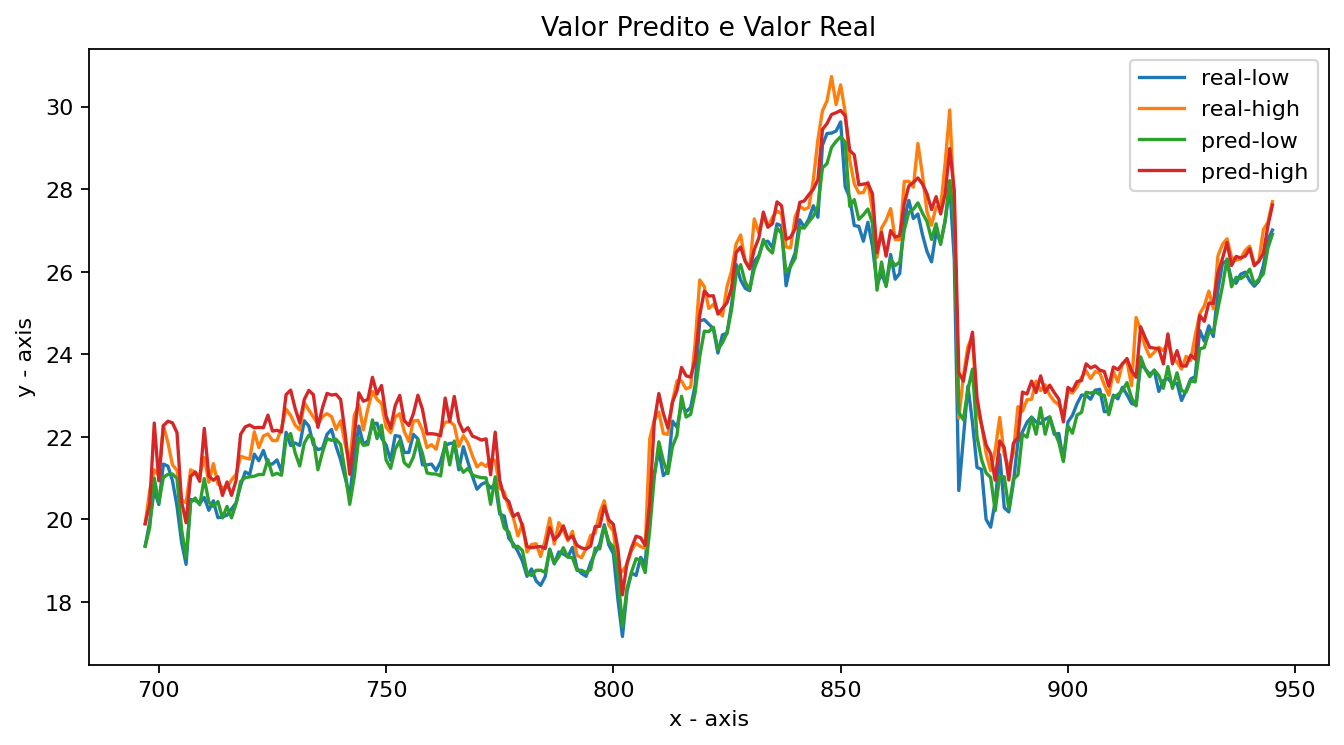

      Feature  Importance
0        open   93.847174
6        ema5    3.228306
13  d-1_close    1.856517
12    d-1_low    0.238877
11   d-1_high    0.214924
10   d-1_open    0.188841
16    d-2_low    0.078378
14   d-2_open    0.055455
7         RSI    0.050400
1    BB_UPPER    0.028460
5        ema9    0.019220
3    BB_LOWER    0.019097
2   BB_MIDDLE    0.017692
15   d-2_high    0.017486
4       ema21    0.016369
17  d-2_close    0.016209
19   d-3_high    0.014158
21  d-3_close    0.012892
20    d-3_low    0.010144
23   d-4_high    0.010123
27   d-5_high    0.009233
25  d-4_close    0.009033
22   d-4_open    0.008663
29  d-5_close    0.007108
26   d-5_open    0.007006
18   d-3_open    0.006866
28    d-5_low    0.005774
24    d-4_low    0.005595
9      RSI-70    0.000000
8      RSI-30    0.000000


In [81]:
_,_,rf,xTrainColumns, dataFrameTeste = exp1(initialDf_PETR4, printPredictValues=True)

featureImp = []
for feat, importance in zip(xTrainColumns, rf.feature_importances_):  
    temp = [feat, importance*100]
    featureImp.append(temp)

fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
print (fT_df.sort_values('Importance', ascending = False))

In [13]:
dataFrameTeste

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close,pred_low,pred_high
697,2020.06.01,19.50,19.89,19.35,19.67,19.114789,19.515257,18.833676,19.338674,19.963541,...,19.33,19.44,18.70,19.03,18.85,18.92,18.63,18.85,19.34048,19.88294
698,2020.06.02,20.08,20.70,19.93,20.70,19.436526,19.910171,19.199117,19.792450,20.917675,...,19.16,19.28,18.53,19.28,19.33,19.44,18.70,19.03,19.76676,20.31800
699,2020.06.03,21.15,21.20,20.71,20.77,20.007684,20.340114,19.702745,20.118300,21.421992,...,19.05,19.43,18.82,19.13,19.16,19.28,18.53,19.28,20.96740,22.00894
700,2020.06.04,20.69,21.07,20.36,20.73,20.235123,20.583409,19.921830,20.322200,21.470431,...,18.91,19.68,18.67,19.68,19.05,19.43,18.82,19.13,20.38398,20.92430
701,2020.06.05,21.57,22.28,21.34,21.38,20.680082,21.148940,20.394553,20.674800,21.881503,...,19.50,19.89,19.35,19.67,18.91,19.68,18.67,19.68,20.95558,21.96102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,2021.05.26,25.91,26.18,25.65,26.09,26.114791,26.354219,25.760657,26.042263,26.470349,...,26.15,26.28,25.72,25.93,25.85,26.35,25.80,26.15,25.70160,26.14418
942,2021.05.27,26.08,26.25,25.77,25.91,26.103194,26.319479,25.763771,25.998175,26.471798,...,26.08,26.31,25.94,25.95,26.15,26.28,25.72,25.93,25.81274,26.25318
943,2021.05.28,26.20,27.02,26.15,26.99,26.135462,26.552986,25.892514,26.328784,27.180120,...,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95,25.88304,26.44098
944,2021.05.31,26.96,27.20,26.78,26.87,26.410308,26.768657,26.188343,26.509189,27.435810,...,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39,26.59280,27.12240


#### Experimento 02: Utilizando Random Forest com indicadores externos
##### Hipóteses plausíveis de serem testadas

In [14]:
PETR4WithExternalIndex = {}
PETR4WithExternalIndex['PETR4Dolar'] = initialDf_PETR4.merge(df_DOLAR, how='inner', on='date', suffixes=('', '_dolar'))
PETR4WithExternalIndex['PETR4VIX'] = initialDf_PETR4.merge(df_VIX, how='inner', on='date', suffixes=('', '_vix'))
PETR4WithExternalIndex['PETR4BTC'] = initialDf_PETR4.merge(df_BTC, how='inner', on='date', suffixes=('', '_BTC'))
PETR4WithExternalIndex['PETR4BVSP'] = initialDf_PETR4.merge(df_BVSP, how='inner', on='date', suffixes=('', '_BVSP'))



#### Verificando importância do Dólar, VIX, BVSP e BTC no Random Forest Regression

In [15]:
for label in ['PETR4Dolar', 'PETR4VIX', 'PETR4BTC', 'PETR4BVSP']:
    print(f"Analisando influencia da feature {label}")
    bd = PETR4WithExternalIndex[label]
    _,_,rf, trainColumns, _ = exp1(bd)

    # importance = rf.feature_importances_
    featureImp = []
    for feat, importance in zip(trainColumns, rf.feature_importances_):  
        temp = [feat, importance*100]
        featureImp.append(temp)

    fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
    print (fT_df.sort_values('Importance', ascending = False).head(15))

Analisando influencia da feature PETR4Dolar
      Feature  Importance
0        open   94.036397
4   EMA_close    2.787416
16  d-1_close    0.929382
3     EMA_low    0.805391
2    EMA_high    0.532855
14   d-1_high    0.194178
13   d-1_open    0.179228
19    d-2_low    0.081750
17   d-2_open    0.046051
15    d-1_low    0.041181
12   LB_close    0.021579
11   UB_close    0.021530
9      UB_low    0.020904
6     LB_open    0.020308
8     LB_high    0.020227
Analisando influencia da feature PETR4VIX
      Feature  Importance
0        open   94.356537
4   EMA_close    2.007834
3     EMA_low    1.291927
16  d-1_close    1.114015
2    EMA_high    0.212360
1    EMA_open    0.179339
13   d-1_open    0.176812
19    d-2_low    0.127847
15    d-1_low    0.074348
17   d-2_open    0.049008
14   d-1_high    0.042325
23    d-3_low    0.022103
7     UB_high    0.020943
8     LB_high    0.020936
10     LB_low    0.020253
Analisando influencia da feature PETR4BTC
      Feature  Importance
0        open 

## Exportando o regressor

In [16]:
_,_,rf, trainColumns, testResult = exp1(initialDf_PETR4)
testResult

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close,pred_low,pred_high
697,2020.06.01,19.50,19.89,19.35,19.67,19.114789,19.515257,18.833676,19.338674,19.963541,...,19.33,19.44,18.70,19.03,18.85,18.92,18.63,18.85,19.34084,19.88432
698,2020.06.02,20.08,20.70,19.93,20.70,19.436526,19.910171,19.199117,19.792450,20.917675,...,19.16,19.28,18.53,19.28,19.33,19.44,18.70,19.03,19.76806,20.32100
699,2020.06.03,21.15,21.20,20.71,20.77,20.007684,20.340114,19.702745,20.118300,21.421992,...,19.05,19.43,18.82,19.13,19.16,19.28,18.53,19.28,20.93314,21.95450
700,2020.06.04,20.69,21.07,20.36,20.73,20.235123,20.583409,19.921830,20.322200,21.470431,...,18.91,19.68,18.67,19.68,19.05,19.43,18.82,19.13,20.35448,20.88992
701,2020.06.05,21.57,22.28,21.34,21.38,20.680082,21.148940,20.394553,20.674800,21.881503,...,19.50,19.89,19.35,19.67,18.91,19.68,18.67,19.68,20.92238,21.90692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,2021.05.26,25.91,26.18,25.65,26.09,26.114791,26.354219,25.760657,26.042263,26.470349,...,26.15,26.28,25.72,25.93,25.85,26.35,25.80,26.15,25.69210,26.14148
942,2021.05.27,26.08,26.25,25.77,25.91,26.103194,26.319479,25.763771,25.998175,26.471798,...,26.08,26.31,25.94,25.95,26.15,26.28,25.72,25.93,25.82202,26.24208
943,2021.05.28,26.20,27.02,26.15,26.99,26.135462,26.552986,25.892514,26.328784,27.180120,...,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95,25.86214,26.40810
944,2021.05.31,26.96,27.20,26.78,26.87,26.410308,26.768657,26.188343,26.509189,27.435810,...,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39,26.60392,27.13664


In [17]:
initialDf_PETR4

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2017.08.01,12.06,12.08,11.86,11.90,11.941241,12.016120,11.797504,11.901463,12.108321,...,11.79,11.79,12.06,12.10,11.77,11.77,11.80,12.02,11.80,11.99
1,2017.08.02,11.91,12.34,11.86,12.25,11.930827,12.124080,11.818336,12.017642,12.333836,...,11.71,11.91,11.84,11.94,11.79,11.79,12.06,12.10,11.77,11.77
2,2017.08.03,12.31,12.39,12.07,12.07,12.057218,12.212720,11.902224,12.035095,12.321517,...,11.85,12.05,11.77,11.91,11.71,11.91,11.84,11.94,11.79,11.79
3,2017.08.04,12.16,12.23,12.03,12.15,12.091479,12.218480,11.944816,12.073397,12.343075,...,11.86,11.90,11.99,12.07,11.85,12.05,11.77,11.91,11.71,11.91
4,2017.08.07,12.11,12.35,12.09,12.29,12.097653,12.262320,11.993211,12.145598,12.443256,...,11.86,12.25,12.06,12.08,11.86,11.90,11.99,12.07,11.85,12.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,2021.05.26,25.91,26.18,25.65,26.09,26.114791,26.354219,25.760657,26.042263,26.470349,...,25.94,25.95,26.15,26.28,25.72,25.93,25.85,26.35,25.80,26.15
942,2021.05.27,26.08,26.25,25.77,25.91,26.103194,26.319479,25.763771,25.998175,26.471798,...,25.99,26.39,26.08,26.31,25.94,25.95,26.15,26.28,25.72,25.93
943,2021.05.28,26.20,27.02,26.15,26.99,26.135462,26.552986,25.892514,26.328784,27.180120,...,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95
944,2021.05.31,26.96,27.20,26.78,26.87,26.410308,26.768657,26.188343,26.509189,27.435810,...,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39


In [18]:
import sys
try:
    del sys.modules["utils"]
except: pass
try:
    del sys.modules["traderSystem"]
except: pass
from utils import exportRegressor, importRegressor
from traderSystem import runStrategy, printStrategyResult, printAmountChart

# rfPath = './myFirstModel.joblib'
# exportRegressor(rf, rfPath)

dfColumns = ['date','time','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']

PETR_df_M15 = pd.read_csv('../Data/PETR4_M15.csv', sep = "\t")
PETR_df_M15.columns = dfColumns
PETR_df_M15 = removeColumns(PETR_df_M15, ['tickvol', 'volume','spread'])
PETR_df_M15['time'] = PETR_df_M15['time'].apply(lambda x: x[:-3])

errorMax, errorMin,rf, trainColumns, testResult = exp1(initialDf_PETR4)
# orders, dfDaily, DD, DDmax, annualReturn, finalMoney, tradesMean = runStrategy(testResult, PETR_df_M15, 100000, 0.001, 0.02, 0.02)
orders, dfDaily, DD, DDmax, annualReturn, finalMoney, tradesMean = runStrategy(testResult, PETR_df_M15, 100000, 0.001, 0, 0)
printStrategyResult(finalMoney, annualReturn, DDmax, tradesMean)
printAmountChart(orders, dfDaily)


Se escolhermos E_max +  teta_max = 0.34 e E_min +  teta_min = 0.24 conforme encontrado nas células acima, então  o resultado fica igual ao do TCC de Adrion
- runStrategy(testResult, PETR_df_M15, 100000, 0.001, 0.34, 0.24) 

Brute Return: 134103.0
Annual Return:34.13
Max DD: 11.63
Mean Trades: 5.14
#####################################
Media de lucro em casos de trades corretos: 0.1335714285714285
Media de prejuízos em casos de trades errados: -0.08073669849931793
Accuracy( percentagem das operações que tiveram lucros): 39.38


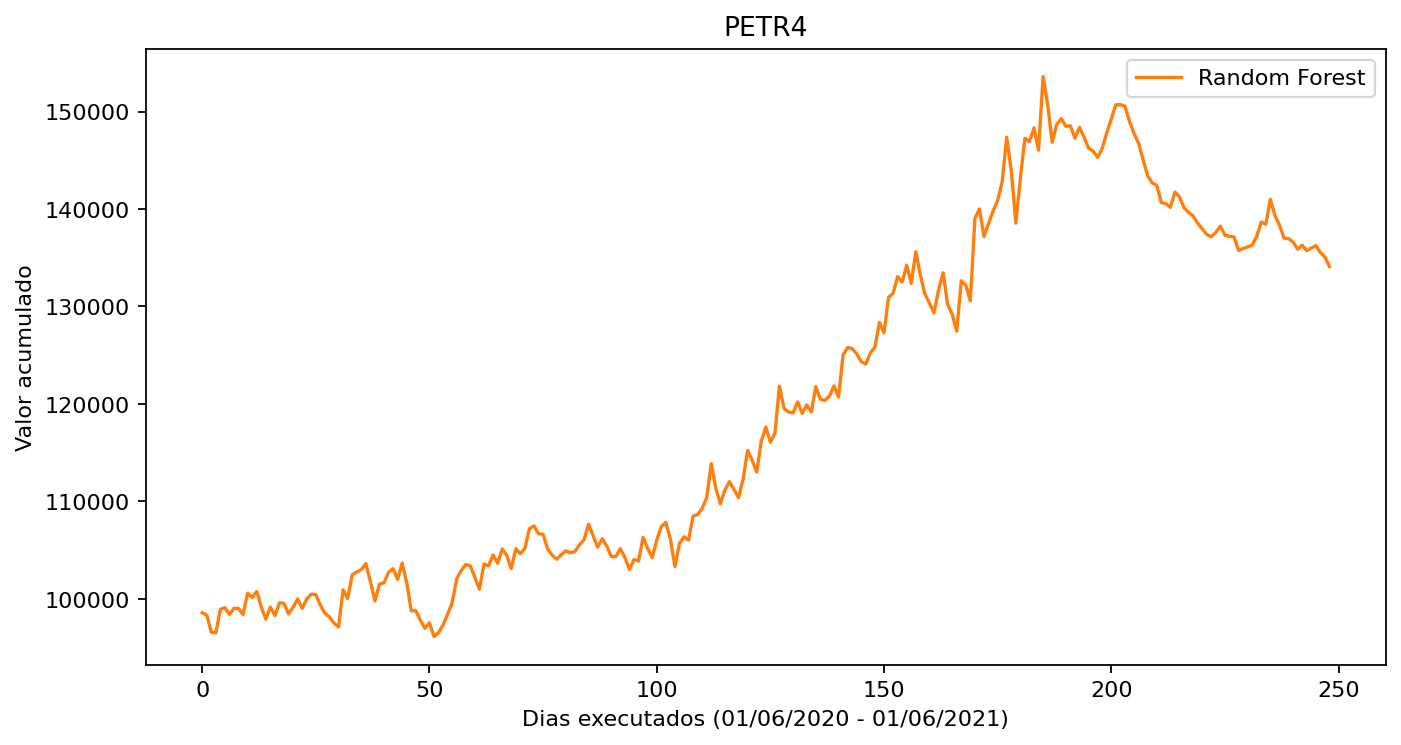

In [23]:
import sys
try:
    del sys.modules["utils"]
except: pass
try:
    del sys.modules["traderSystem"]
except: pass
from utils import exportRegressor, importRegressor
from traderSystem import runStrategy, printStrategyResult, printAmountChart

# rfPath = './myFirstModel.joblib'
# exportRegressor(rf, rfPath)

dfColumns = ['date','time','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']

PETR_df_M15 = pd.read_csv('../Data/PETR4_M15.csv', sep = "\t")
PETR_df_M15.columns = dfColumns
PETR_df_M15 = removeColumns(PETR_df_M15, ['tickvol', 'volume','spread'])
PETR_df_M15['time'] = PETR_df_M15['time'].apply(lambda x: x[:-3])

errorMax, errorMin,rf, trainColumns, testResult = exp1(initialDf_PETR4)
orders, dfDaily, DD, DDmax, annualReturn, finalMoney, tradesMean = runStrategy(testResult, PETR_df_M15, 100000, 0.001, 0.02, 0.02)
# orders, dfDaily, DD, DDmax, annualReturn, finalMoney, tradesMean = runStrategy(testResult, PETR_df_M15, 100000, 0.001, 0, 0)
printStrategyResult(finalMoney, annualReturn, DDmax, tradesMean)
printAmountChart(orders, dfDaily)